In [1]:
%config Completer.use_jedi = False
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt



np.random.seed(1)
tf.random.set_random_seed(1)

mnist = input_data.read_data_sets('MNIST_data')

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [2]:
def get_noise(n_samples, z_dim,isFlatten = True):
    
    nz_dim = None
    
    if isFlatten:
        nz_dim = 1
        for i in range(len(z_dim)):
            nz_dim *= z_dim[i]
    else:        
        nz_dim = z_dim

    return np.random.uniform(-1.,1.,(n_samples,nz_dim))


In [3]:
def showImage(image_tensor, num_images=10, size=(1, 28, 28)):
        
    image_tensor = np.reshape(image_tensor,(image_tensor.shape[0],size[1],size[2],size[0]))
    
    for i in range(num_images):
        
        plt.imshow(image_tensor[i])
        plt.show()
    

In [4]:
def Generator(inp,hid_size,out_size,reuse=False):
    
    with tf.variable_scope("GAN/Generator",reuse=reuse):
    
            h1 = tf.layers.dense(inp,hid_size,activation=tf.nn.relu)
            b1 = tf.layers.batch_normalization(h1)
            
            h2 = tf.layers.dense(b1,hid_size*2,activation=tf.nn.relu)
            b2 = tf.layers.batch_normalization(h2)
            
            h3 = tf.layers.dense(b2,hid_size*4,activation=tf.nn.relu)
            b3 = tf.layers.batch_normalization(h3)
            
            h4 = tf.layers.dense(b3,hid_size*8,activation=tf.nn.relu)
            b4 = tf.layers.batch_normalization(h4)
            
            out = tf.layers.dense(b4,out_size)
        
    return out
        
        

In [5]:
def Discriminator(inp,hid_size,out_size,reuse=False):

    with tf.variable_scope("GAN/Discriminator",reuse=reuse):
        
        h1 = tf.layers.dense(inp,hid_size*4,activation=tf.nn.relu)
        h2 = tf.layers.dense(h1,hid_size*2,activation=tf.nn.relu)
        h3 = tf.layers.dense(h2,hid_size)
        out = tf.layers.dense(h3,out_size)
        
    return out
        
        

In [6]:
def discLoss(fake_preds,real_preds):
    
    
    disc_real_pred = real_preds
    disc_real_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits = disc_real_pred, labels = tf.ones_like(disc_real_pred))
    
    disc_fake_pred = fake_preds
    disc_fake_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits = disc_fake_pred, labels = tf.zeros_like(disc_fake_pred))
    
    disc_loss = tf.reduce_mean(disc_fake_loss + disc_real_loss)

    return disc_loss

In [7]:
def genLoss(fake_preds):
    
    disc_fake_pred = fake_preds
    gen_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits = disc_fake_pred, labels = tf.ones_like(disc_fake_pred))
    
    return tf.reduce_mean(gen_loss)

In [8]:
def train(lr = 0.001,n_epochs = 10):
    
    num_batches = 250
    noise_dim = 64
    hidden_size = 128
    img_size = (1,28,28)

    real_dim = img_size[0]*img_size[1]*img_size[2]
    
    noiseData = get_noise(mnist.train.images.shape[0],noise_dim,False)
                            
    Z = tf.placeholder(tf.float64,[None,noise_dim])
    X = tf.placeholder(tf.float64,[None,real_dim])

    fake_imgs = Generator(inp=Z,hid_size=hidden_size,out_size=real_dim)
                
    real_preds = Discriminator(inp=X,hid_size=hidden_size,out_size=1)
    fake_preds = Discriminator(inp=fake_imgs,hid_size=hidden_size,out_size=1,reuse=True)

    
    disc_loss = discLoss(fake_preds,real_preds)
    gen_loss = genLoss(fake_preds)

    gen_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="GAN/Generator")
    disc_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="GAN/Discriminator")

    gen_step = tf.train.AdamOptimizer(learning_rate=lr).minimize(gen_loss,var_list = gen_vars) # G Train step
    disc_step = tf.train.AdamOptimizer(learning_rate=lr).minimize(disc_loss,var_list = disc_vars) # D Train step

    with tf.Session() as sess:
        
        tf.global_variables_initializer().run(session=sess)        


        for i in range(n_epochs):
            
            for j in range(int(mnist.train.images.shape[0]/num_batches)-1):
                
                X_batch = mnist.train.images[num_batches*j:num_batches*(j+1),:]
                Z_batch = noiseData[num_batches*j:num_batches*(j+1),:]

                _, dloss = sess.run([disc_step, disc_loss], feed_dict={X: X_batch, Z: Z_batch})

                _, gloss = sess.run([gen_step, gen_loss], feed_dict={Z: Z_batch})
                    
                if j%100 == 0:
                    print (f"steps: {j} Discriminator loss: {dloss} Generator loss: {gloss}")



            print("Fake images : ")
            showImage(Generator(inp=Z_batch,hid_size=hidden_size,out_size=real_dim,reuse=True).eval(feed_dict={Z: Z_batch}))

            print("Real images : ")
            showImage(image_tensor=X_batch)

            print(dloss.shape,gloss.shape)
            print (f"Epochs: {i} Discriminator loss: {dloss} Generator loss: {gloss}")


Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
steps: 0 Discriminator loss: 1.4311795849468971 Generator loss: 0.8196136646790553
steps: 100 Discriminator loss: 0.9982632198362889 Generator loss: 3.4456589876878727
steps: 200 Discriminator loss: 0.8386828805546068 Generator loss: 6.472225113824645
Fake images : 


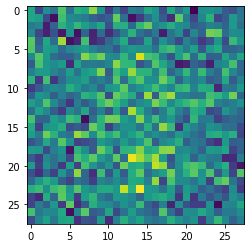

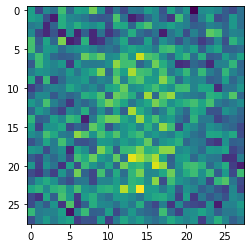

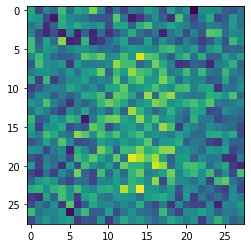

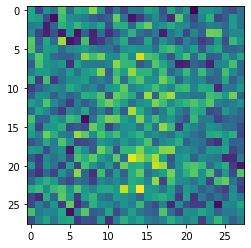

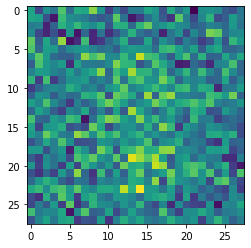

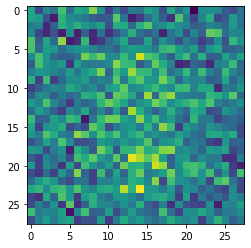

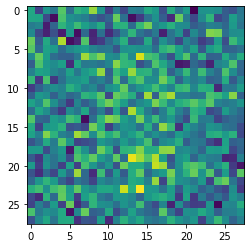

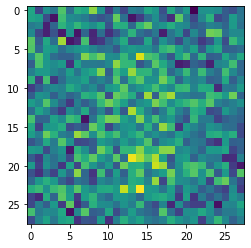

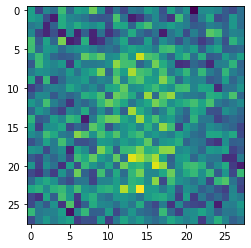

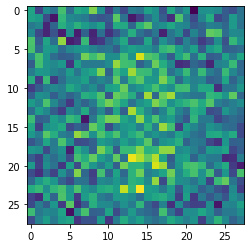

Real images : 


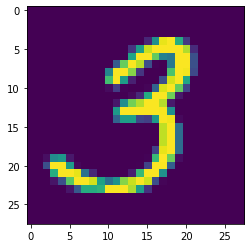

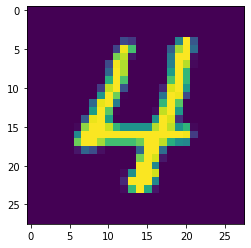

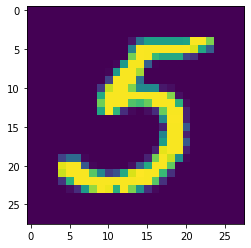

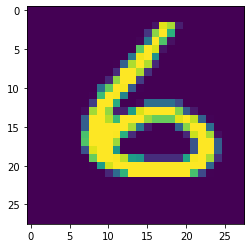

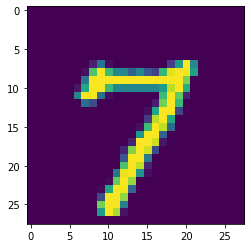

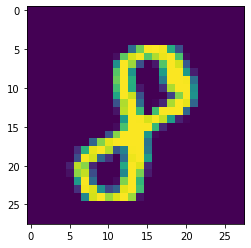

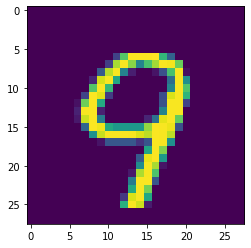

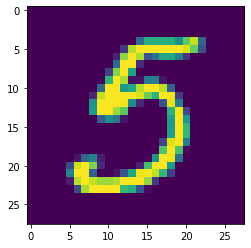

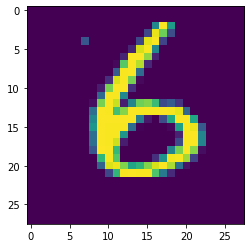

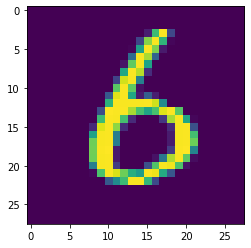

() ()
Epochs: 0 Discriminator loss: 7.547441792114051 Generator loss: 12.339553937900071
steps: 0 Discriminator loss: 5.614000347711367 Generator loss: 18.44725417493696
steps: 100 Discriminator loss: 0.31412366940576536 Generator loss: 4.422859902379951
steps: 200 Discriminator loss: 0.8199388136635446 Generator loss: 6.20633655613678
Fake images : 


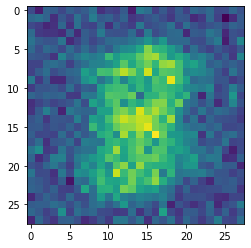

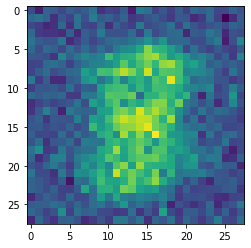

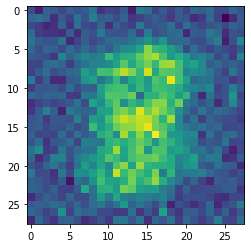

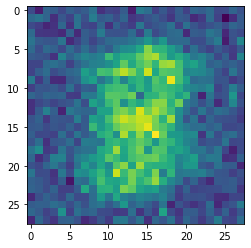

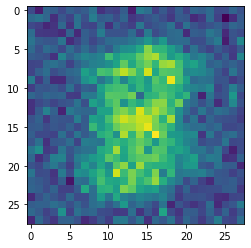

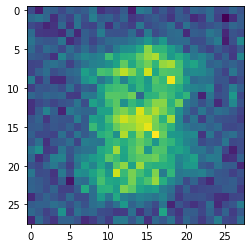

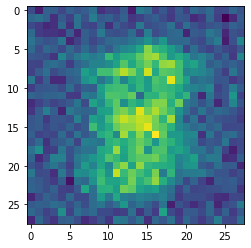

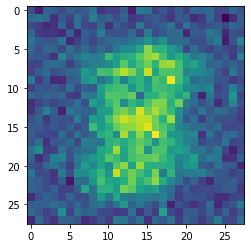

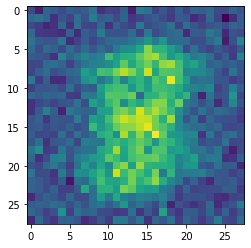

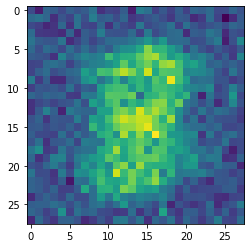

Real images : 


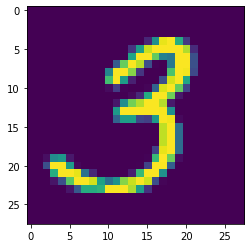

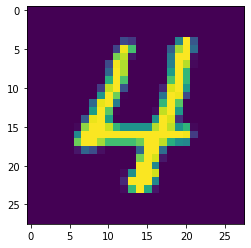

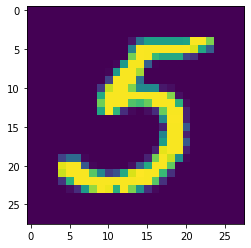

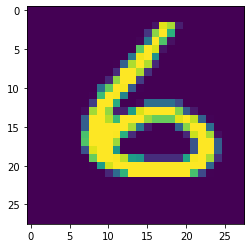

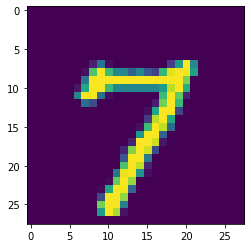

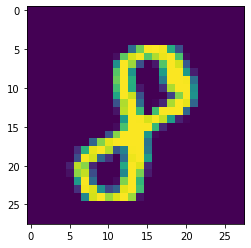

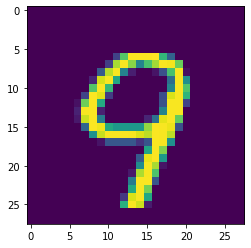

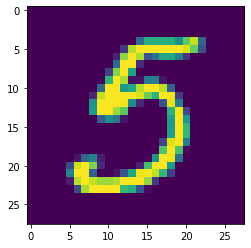

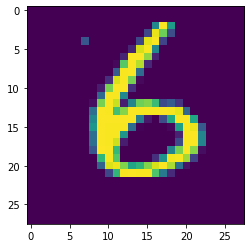

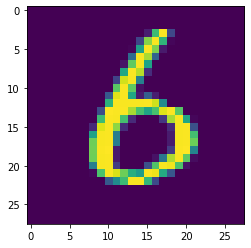

() ()
Epochs: 1 Discriminator loss: 0.6348607815117712 Generator loss: 5.403885405641701
steps: 0 Discriminator loss: 0.9102808076306407 Generator loss: 6.727406167460814
steps: 100 Discriminator loss: 1.0444088289167894 Generator loss: 5.468369815557573
steps: 200 Discriminator loss: 0.056539112072869394 Generator loss: 11.37390725656655
Fake images : 


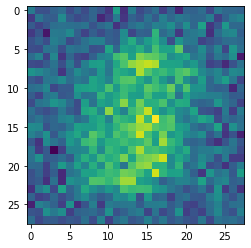

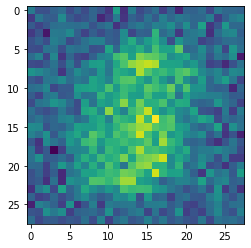

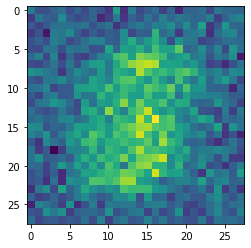

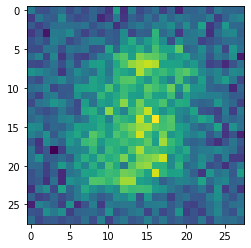

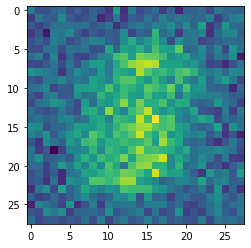

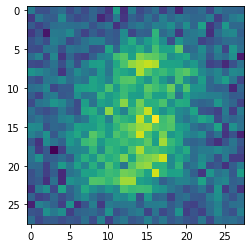

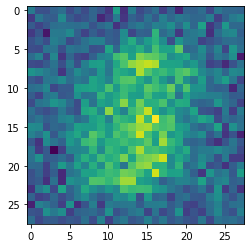

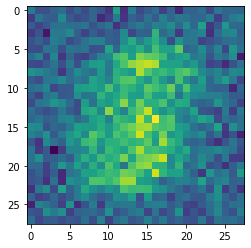

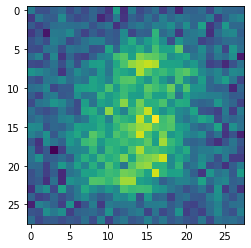

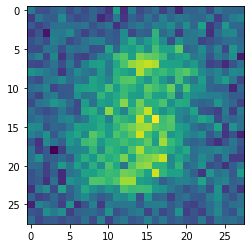

Real images : 


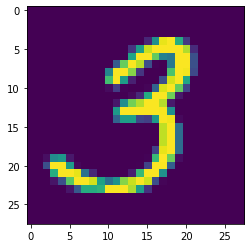

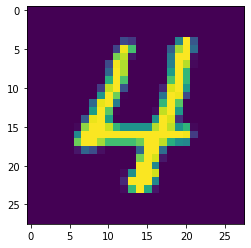

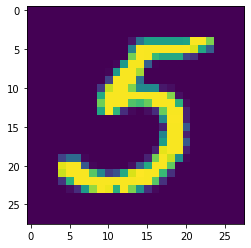

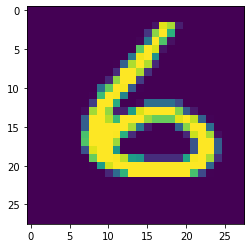

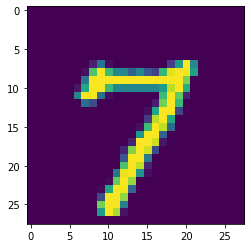

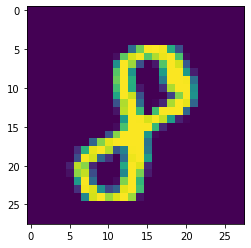

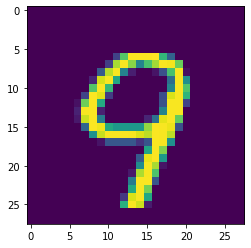

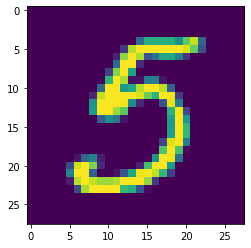

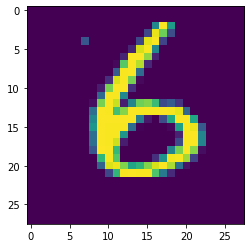

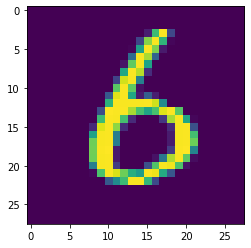

() ()
Epochs: 2 Discriminator loss: 0.3769086741669606 Generator loss: 8.494488317888832
steps: 0 Discriminator loss: 0.5289203545125089 Generator loss: 7.650239427235729
steps: 100 Discriminator loss: 0.16684624095580228 Generator loss: 5.222321314093139
steps: 200 Discriminator loss: 0.09144087620029054 Generator loss: 8.078492419518977
Fake images : 


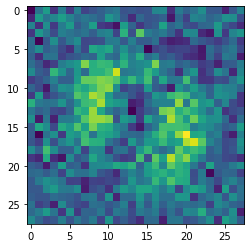

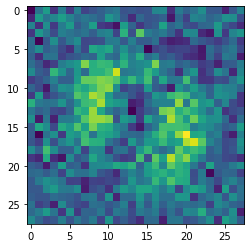

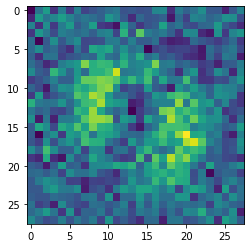

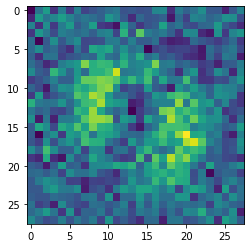

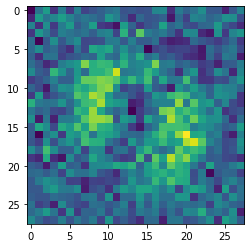

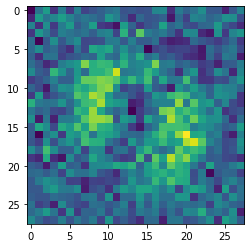

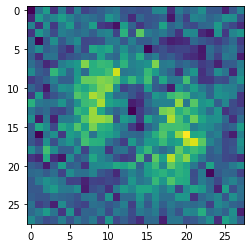

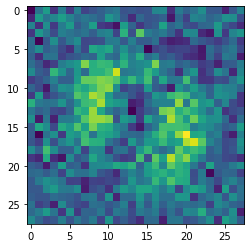

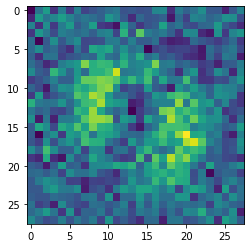

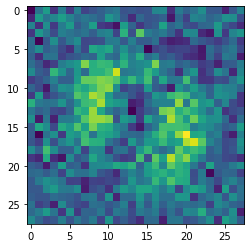

Real images : 


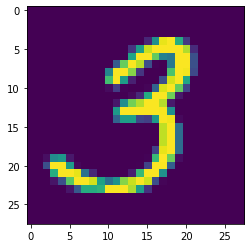

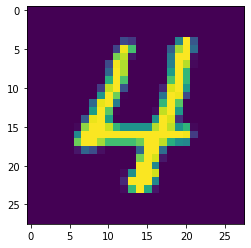

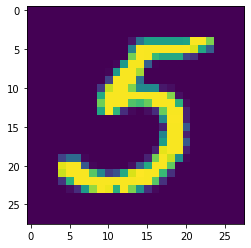

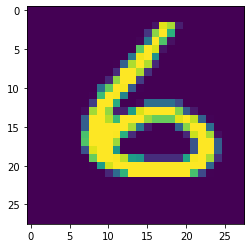

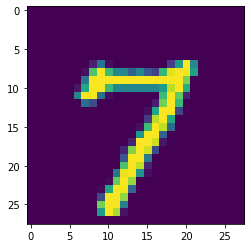

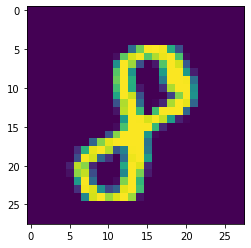

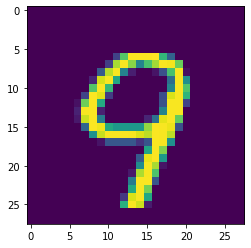

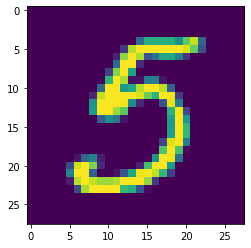

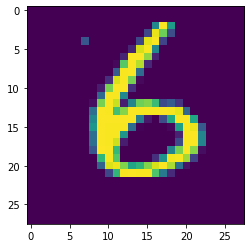

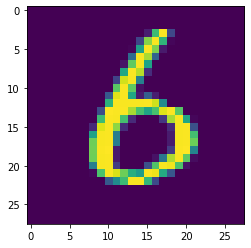

() ()
Epochs: 3 Discriminator loss: 0.4044469092922553 Generator loss: 6.062014698927645
steps: 0 Discriminator loss: 0.2988794063455524 Generator loss: 5.363953896439062
steps: 100 Discriminator loss: 0.7809458802162641 Generator loss: 8.36744786679693
steps: 200 Discriminator loss: 0.18933915666039586 Generator loss: 3.9800467266628075
Fake images : 


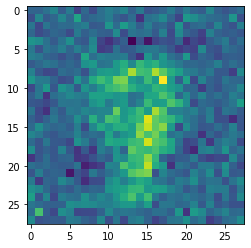

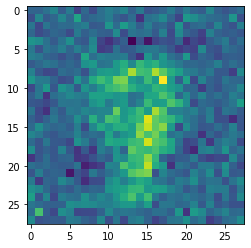

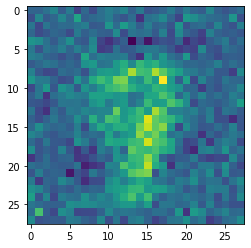

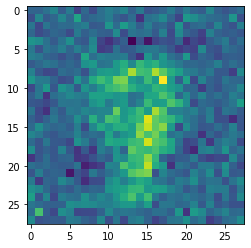

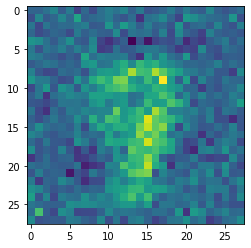

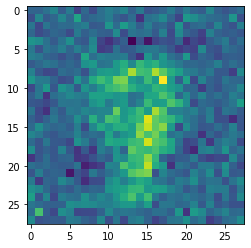

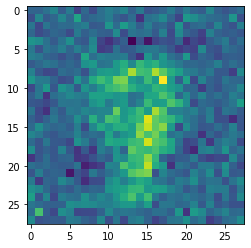

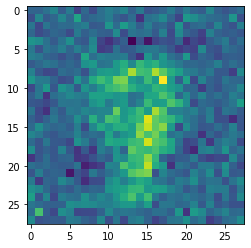

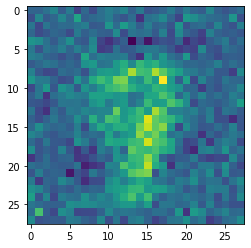

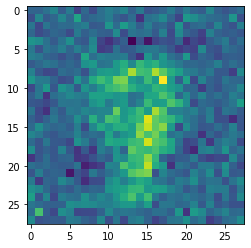

Real images : 


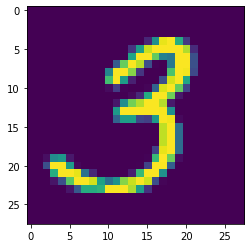

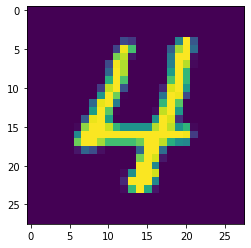

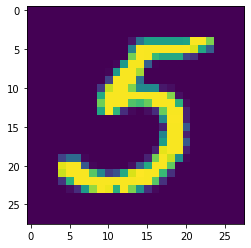

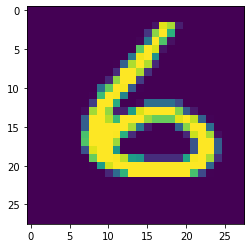

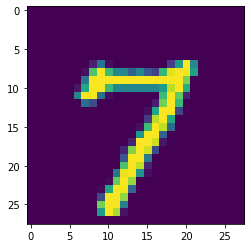

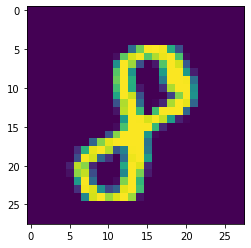

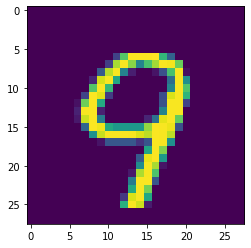

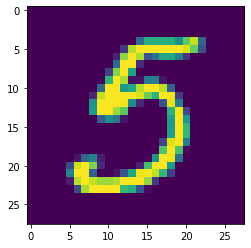

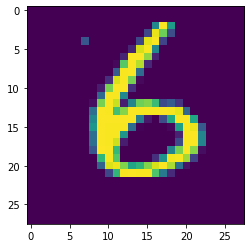

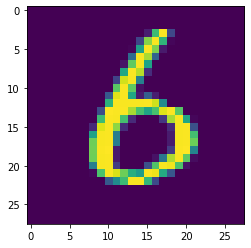

() ()
Epochs: 4 Discriminator loss: 0.6739847070257705 Generator loss: 4.945412880993763
steps: 0 Discriminator loss: 0.878094459124425 Generator loss: 6.953401155858247
steps: 100 Discriminator loss: 0.5460659743368289 Generator loss: 7.41046308809844
steps: 200 Discriminator loss: 0.3033105751436783 Generator loss: 13.058978335377056
Fake images : 


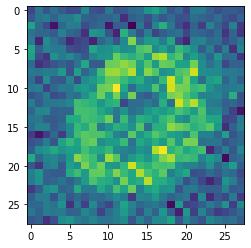

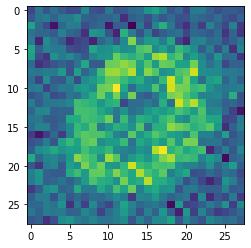

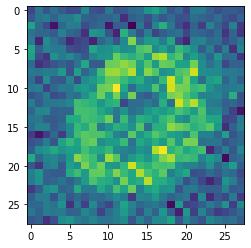

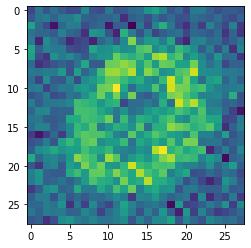

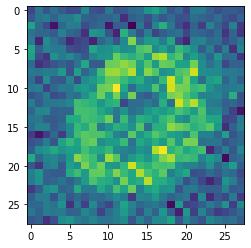

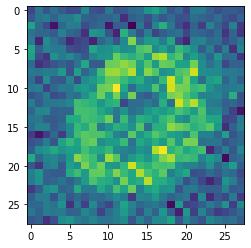

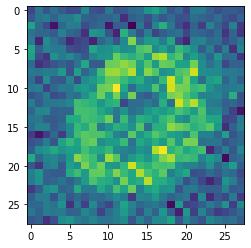

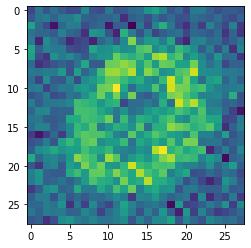

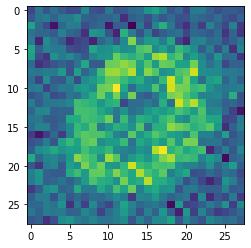

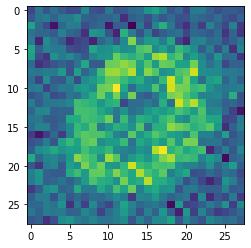

Real images : 


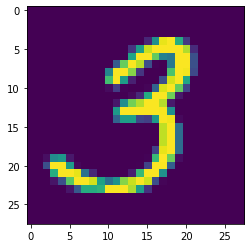

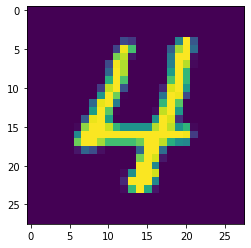

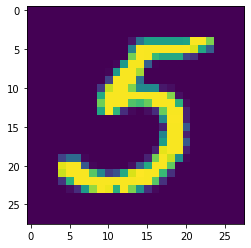

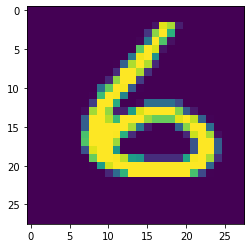

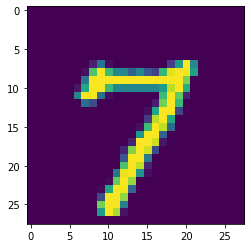

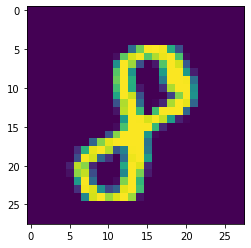

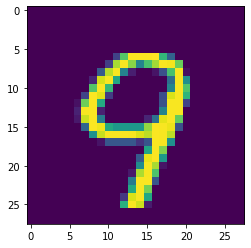

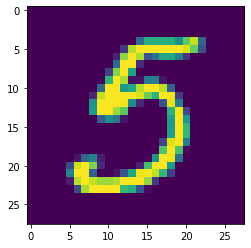

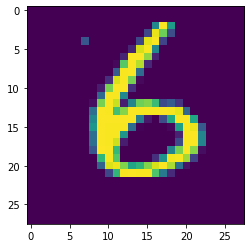

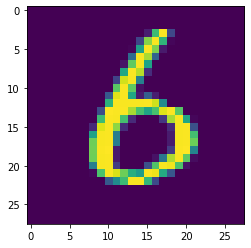

() ()
Epochs: 5 Discriminator loss: 0.11262275801445629 Generator loss: 5.536545026256398
steps: 0 Discriminator loss: 0.14371714158057408 Generator loss: 4.686813333464318
steps: 100 Discriminator loss: 0.41119533546608905 Generator loss: 6.25856624013583
steps: 200 Discriminator loss: 0.03394974097738699 Generator loss: 7.271658305055129
Fake images : 


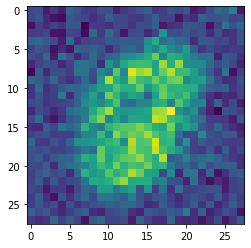

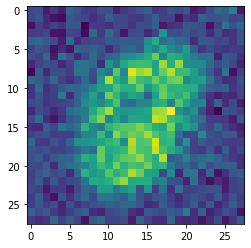

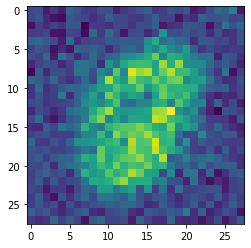

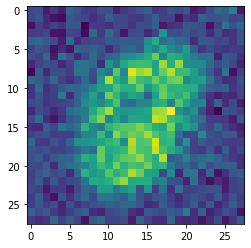

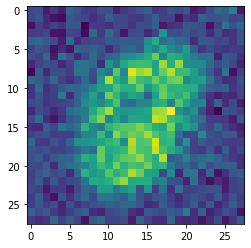

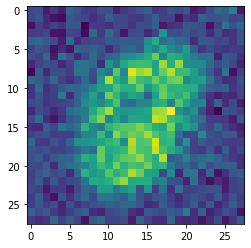

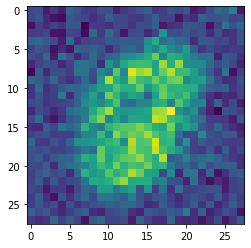

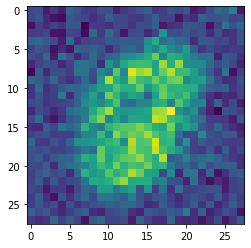

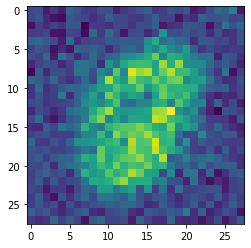

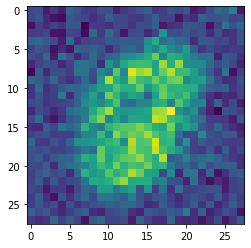

Real images : 


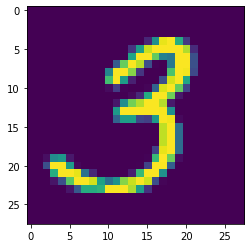

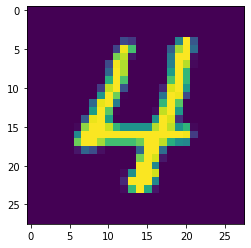

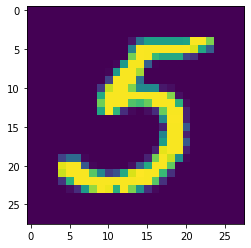

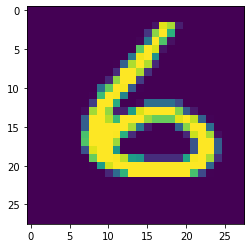

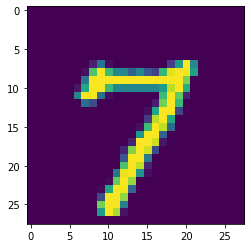

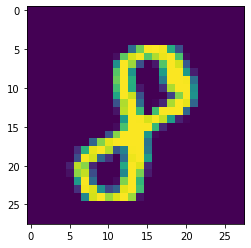

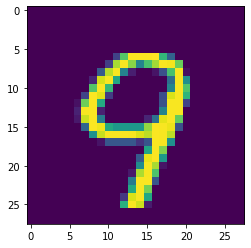

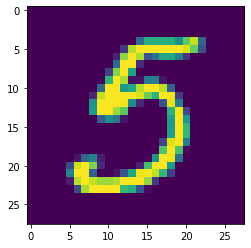

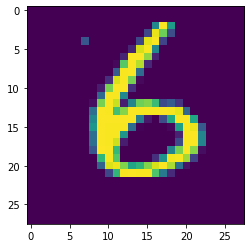

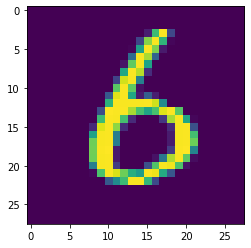

() ()
Epochs: 6 Discriminator loss: 0.9001296193675923 Generator loss: 7.7313732907587145
steps: 0 Discriminator loss: 0.7862924999530244 Generator loss: 5.829650086844071
steps: 100 Discriminator loss: 0.8530569572368939 Generator loss: 8.910946371789072
steps: 200 Discriminator loss: 0.13026450203336148 Generator loss: 6.34918568853912
Fake images : 


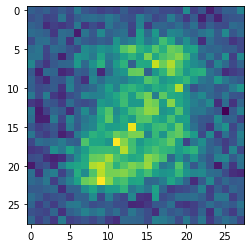

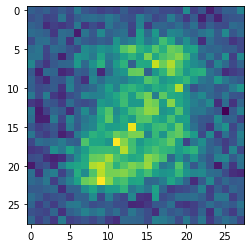

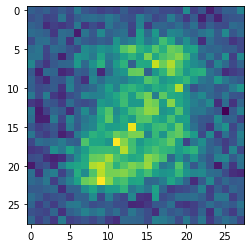

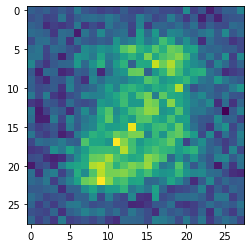

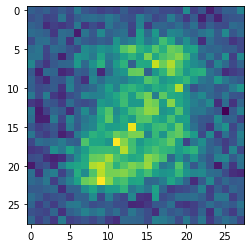

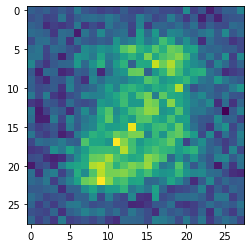

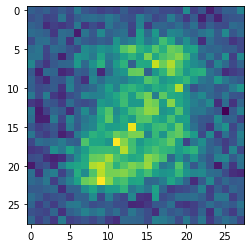

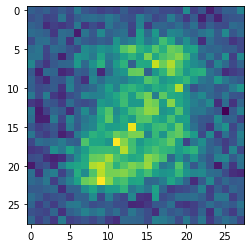

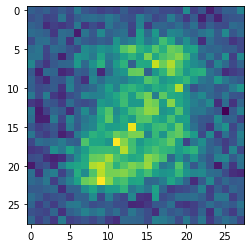

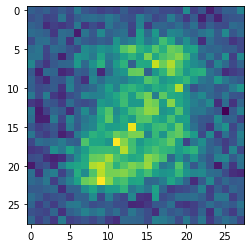

Real images : 


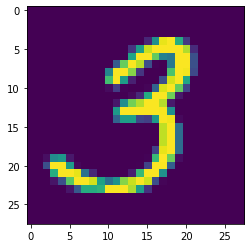

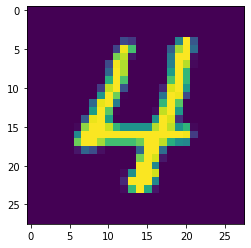

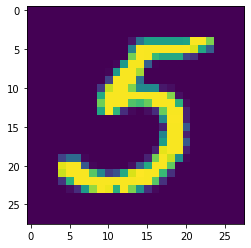

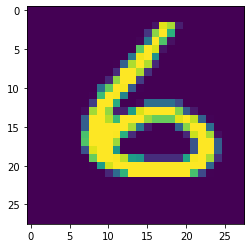

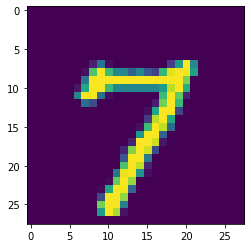

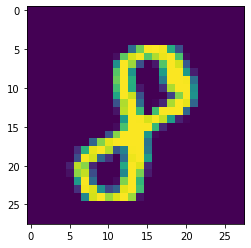

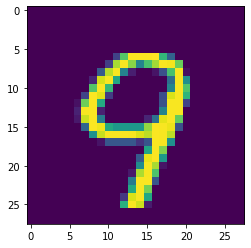

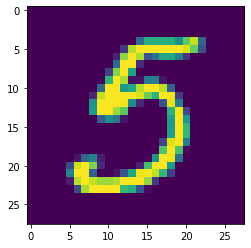

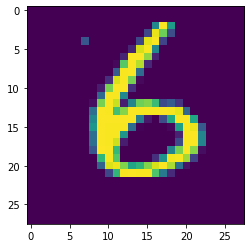

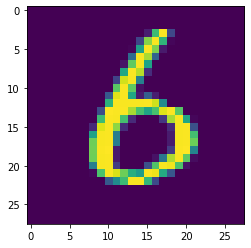

() ()
Epochs: 7 Discriminator loss: 0.19023739896821532 Generator loss: 8.622267658809104
steps: 0 Discriminator loss: 0.3231727754674467 Generator loss: 7.320953392054134
steps: 100 Discriminator loss: 2.6776659240599234 Generator loss: 25.99488879503194
steps: 200 Discriminator loss: 0.1501868040689776 Generator loss: 8.315814644135443
Fake images : 


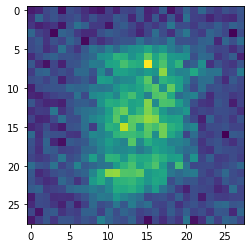

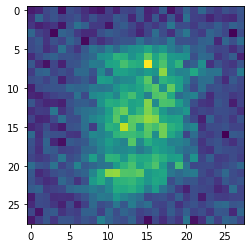

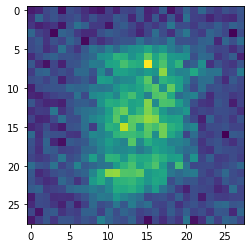

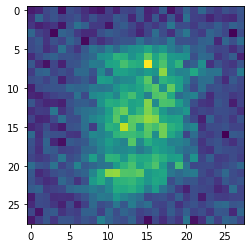

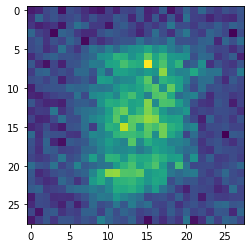

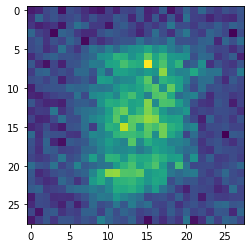

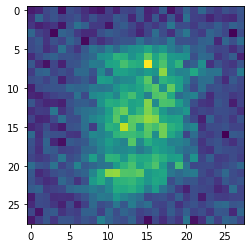

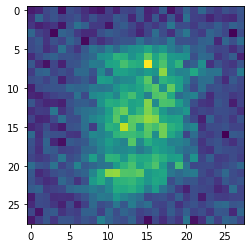

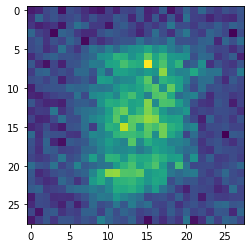

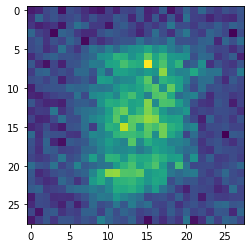

Real images : 


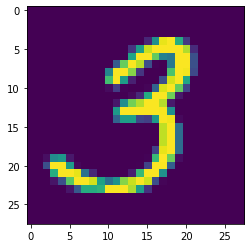

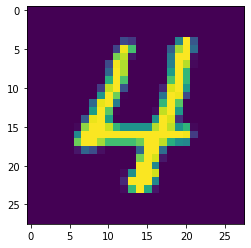

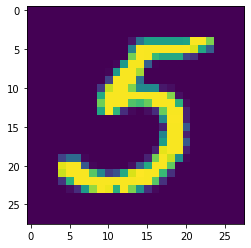

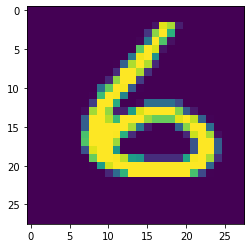

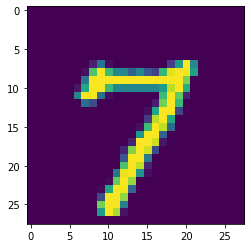

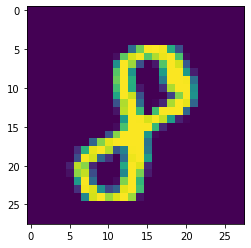

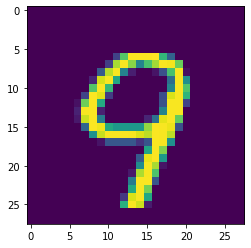

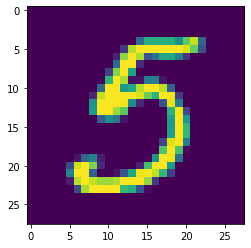

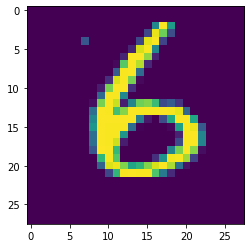

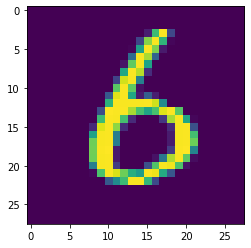

() ()
Epochs: 8 Discriminator loss: 0.09146017864080716 Generator loss: 4.628751367706746
steps: 0 Discriminator loss: 0.11071259575585693 Generator loss: 5.52132512821356
steps: 100 Discriminator loss: 0.03065374548171272 Generator loss: 7.675382961402131
steps: 200 Discriminator loss: 0.04127665383723921 Generator loss: 9.930419045800885
Fake images : 


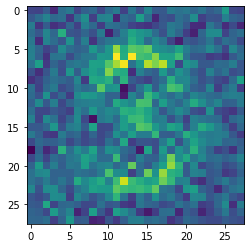

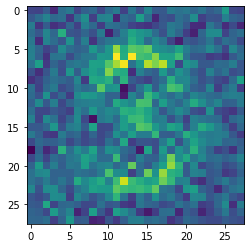

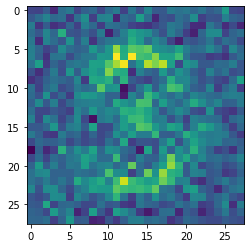

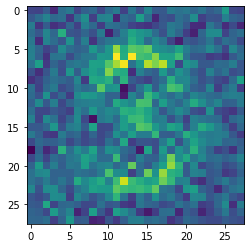

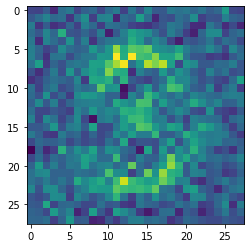

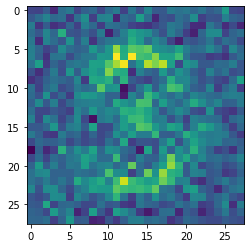

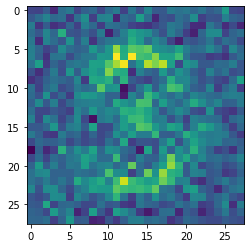

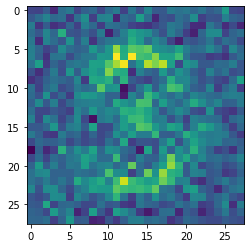

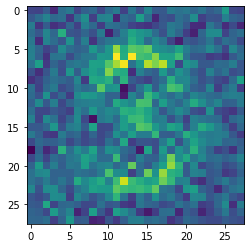

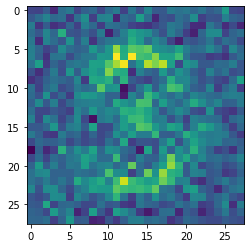

Real images : 


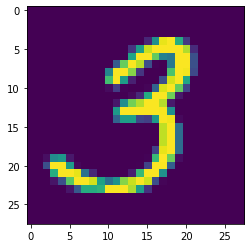

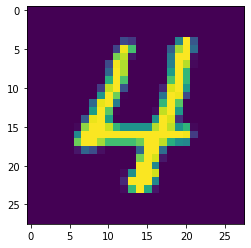

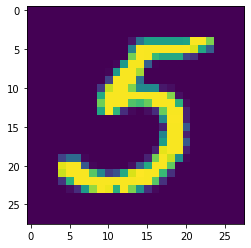

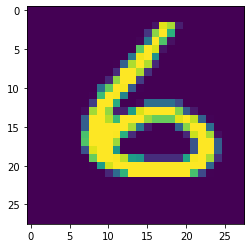

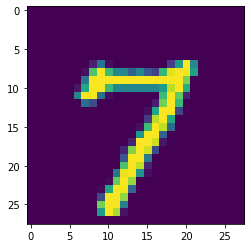

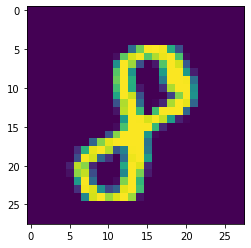

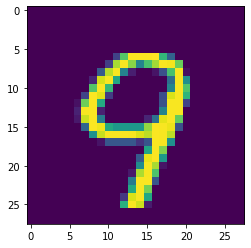

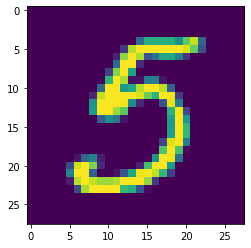

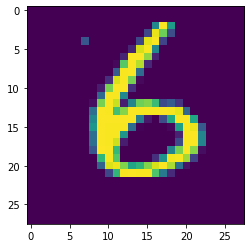

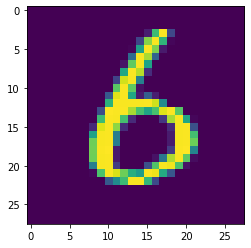

() ()
Epochs: 9 Discriminator loss: 0.10167874928229158 Generator loss: 6.472558483169565


In [9]:
train()